In [1]:
import re
import time
import math
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [2]:
# Load data
wine_qual = pd.read_csv('C:/Users/keith/Desktop/Thinkful/winequality-red (1).csv',encoding = "ISO-8859-1",sep='\;',header=0)

pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
wine_qual.head()

,"""fixed acidity""","""volatile acidity""","""citric acid""","""residual sugar""","""chlorides""","""free sulfur dioxide""","""total sulfur dioxide""","""density""","""pH""","""sulphates""","""alcohol""","""quality"""
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Data Cleaning

In [4]:
# checking data types

wine_qual.dtypes

"fixed acidity"           float64
"volatile acidity"        float64
"citric acid"             float64
"residual sugar"          float64
"chlorides"               float64
"free sulfur dioxide"     float64
"total sulfur dioxide"    float64
"density"                 float64
"pH"                      float64
"sulphates"               float64
"alcohol"                 float64
"quality"                   int64
dtype: object

In [5]:
# check for null values

wine_qual.isnull().sum()

"fixed acidity"           0
"volatile acidity"        0
"citric acid"             0
"residual sugar"          0
"chlorides"               0
"free sulfur dioxide"     0
"total sulfur dioxide"    0
"density"                 0
"pH"                      0
"sulphates"               0
"alcohol"                 0
"quality"                 0
dtype: int64

In [6]:
# Make feature names easier to work with

wine_qual.columns = wine_qual.columns.str.replace(' ','_')
wine_qual.columns = wine_qual.columns.str.replace('"','')

In [7]:
wine_qual.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Exploratory data analysis

In [8]:
#Descriptive statistics

wine_qual.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


There may be a few outliers in free_sulfur_dioxide and total_sulfur_dioxide. The standard deviations are high in these features.

In [9]:
print(wine_qual.quality.value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


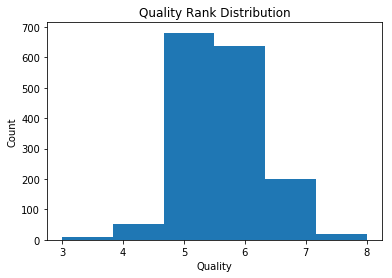

In [10]:
plt.hist(wine_qual.quality,bins=6)
plt.title("Quality Rank Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

The target variable has 6 classes. 3, 8, and 4 are very imbalanced from 5, 6, and 7 but altogether they are normally distributed. It may effect decision trees.

In [11]:
 wine_qual['quality']=wine_qual.quality.replace([3,4,5,6,7,8],[0,0,0,1,1,1])

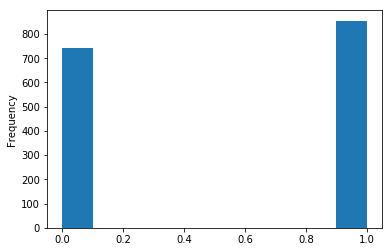

In [12]:
wine_qual.quality.plot(kind='hist')

In [13]:
wine_qual.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [14]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

111 new random picked points


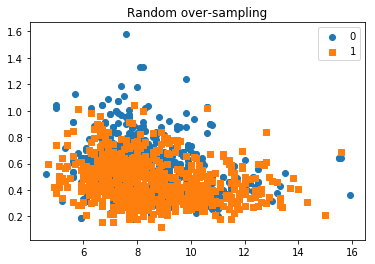

In [15]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(wine_qual.drop('quality',1), wine_qual.quality)

print(X_ros.shape[0] - wine_qual.drop('quality',1).shape[0], 'new random picked points')

 
plot_2d_space(X_ros , y_ros , 'Random over-sampling')


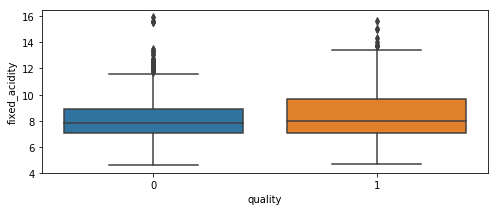

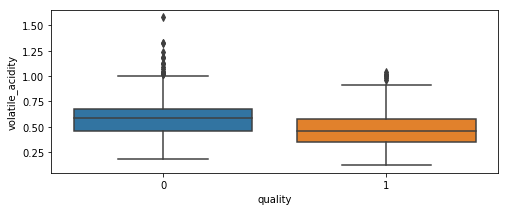

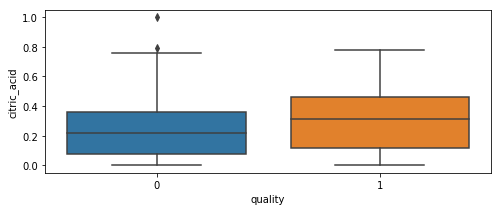

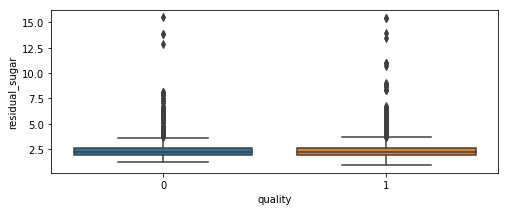

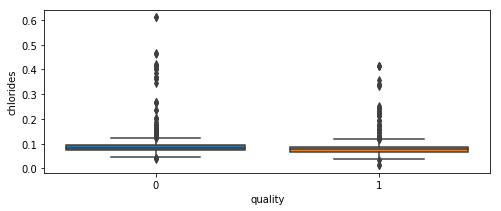

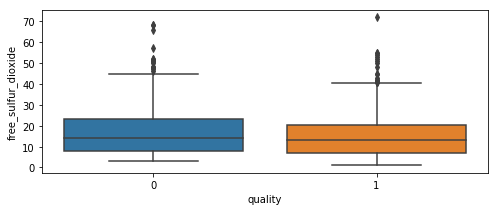

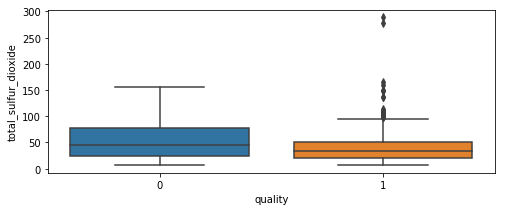

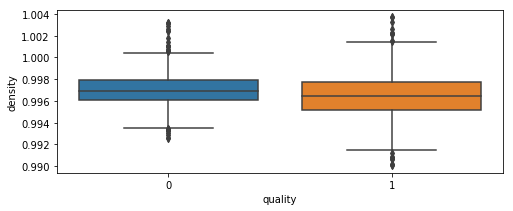

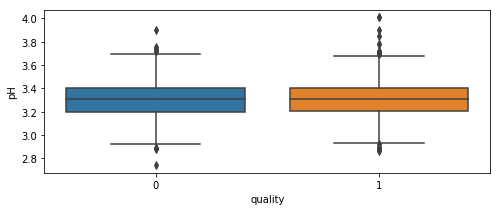

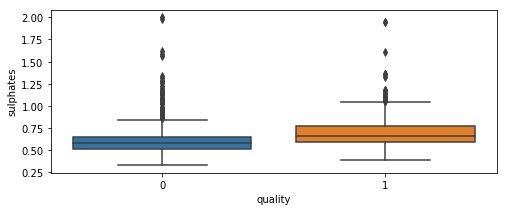

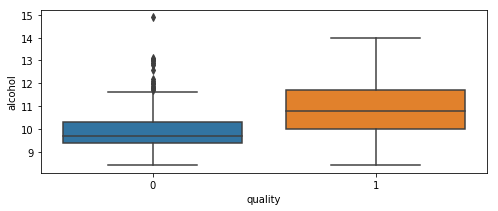

In [16]:
for i in  wine_qual.drop('quality',1):
    fig, ax = pyplot.subplots(figsize=(8, 3))
    sns.boxplot(x='quality', y= i, data=wine_qual,ax=ax)

From the boxplots it seems that higher alcohol and higher citric acid and sulfates have the greatest effect on the best wine and higher PH, density, and volatile acidity, have the greatest effect on the worst wines. The other variables seem to contribute little effect across the scale of wine quality.

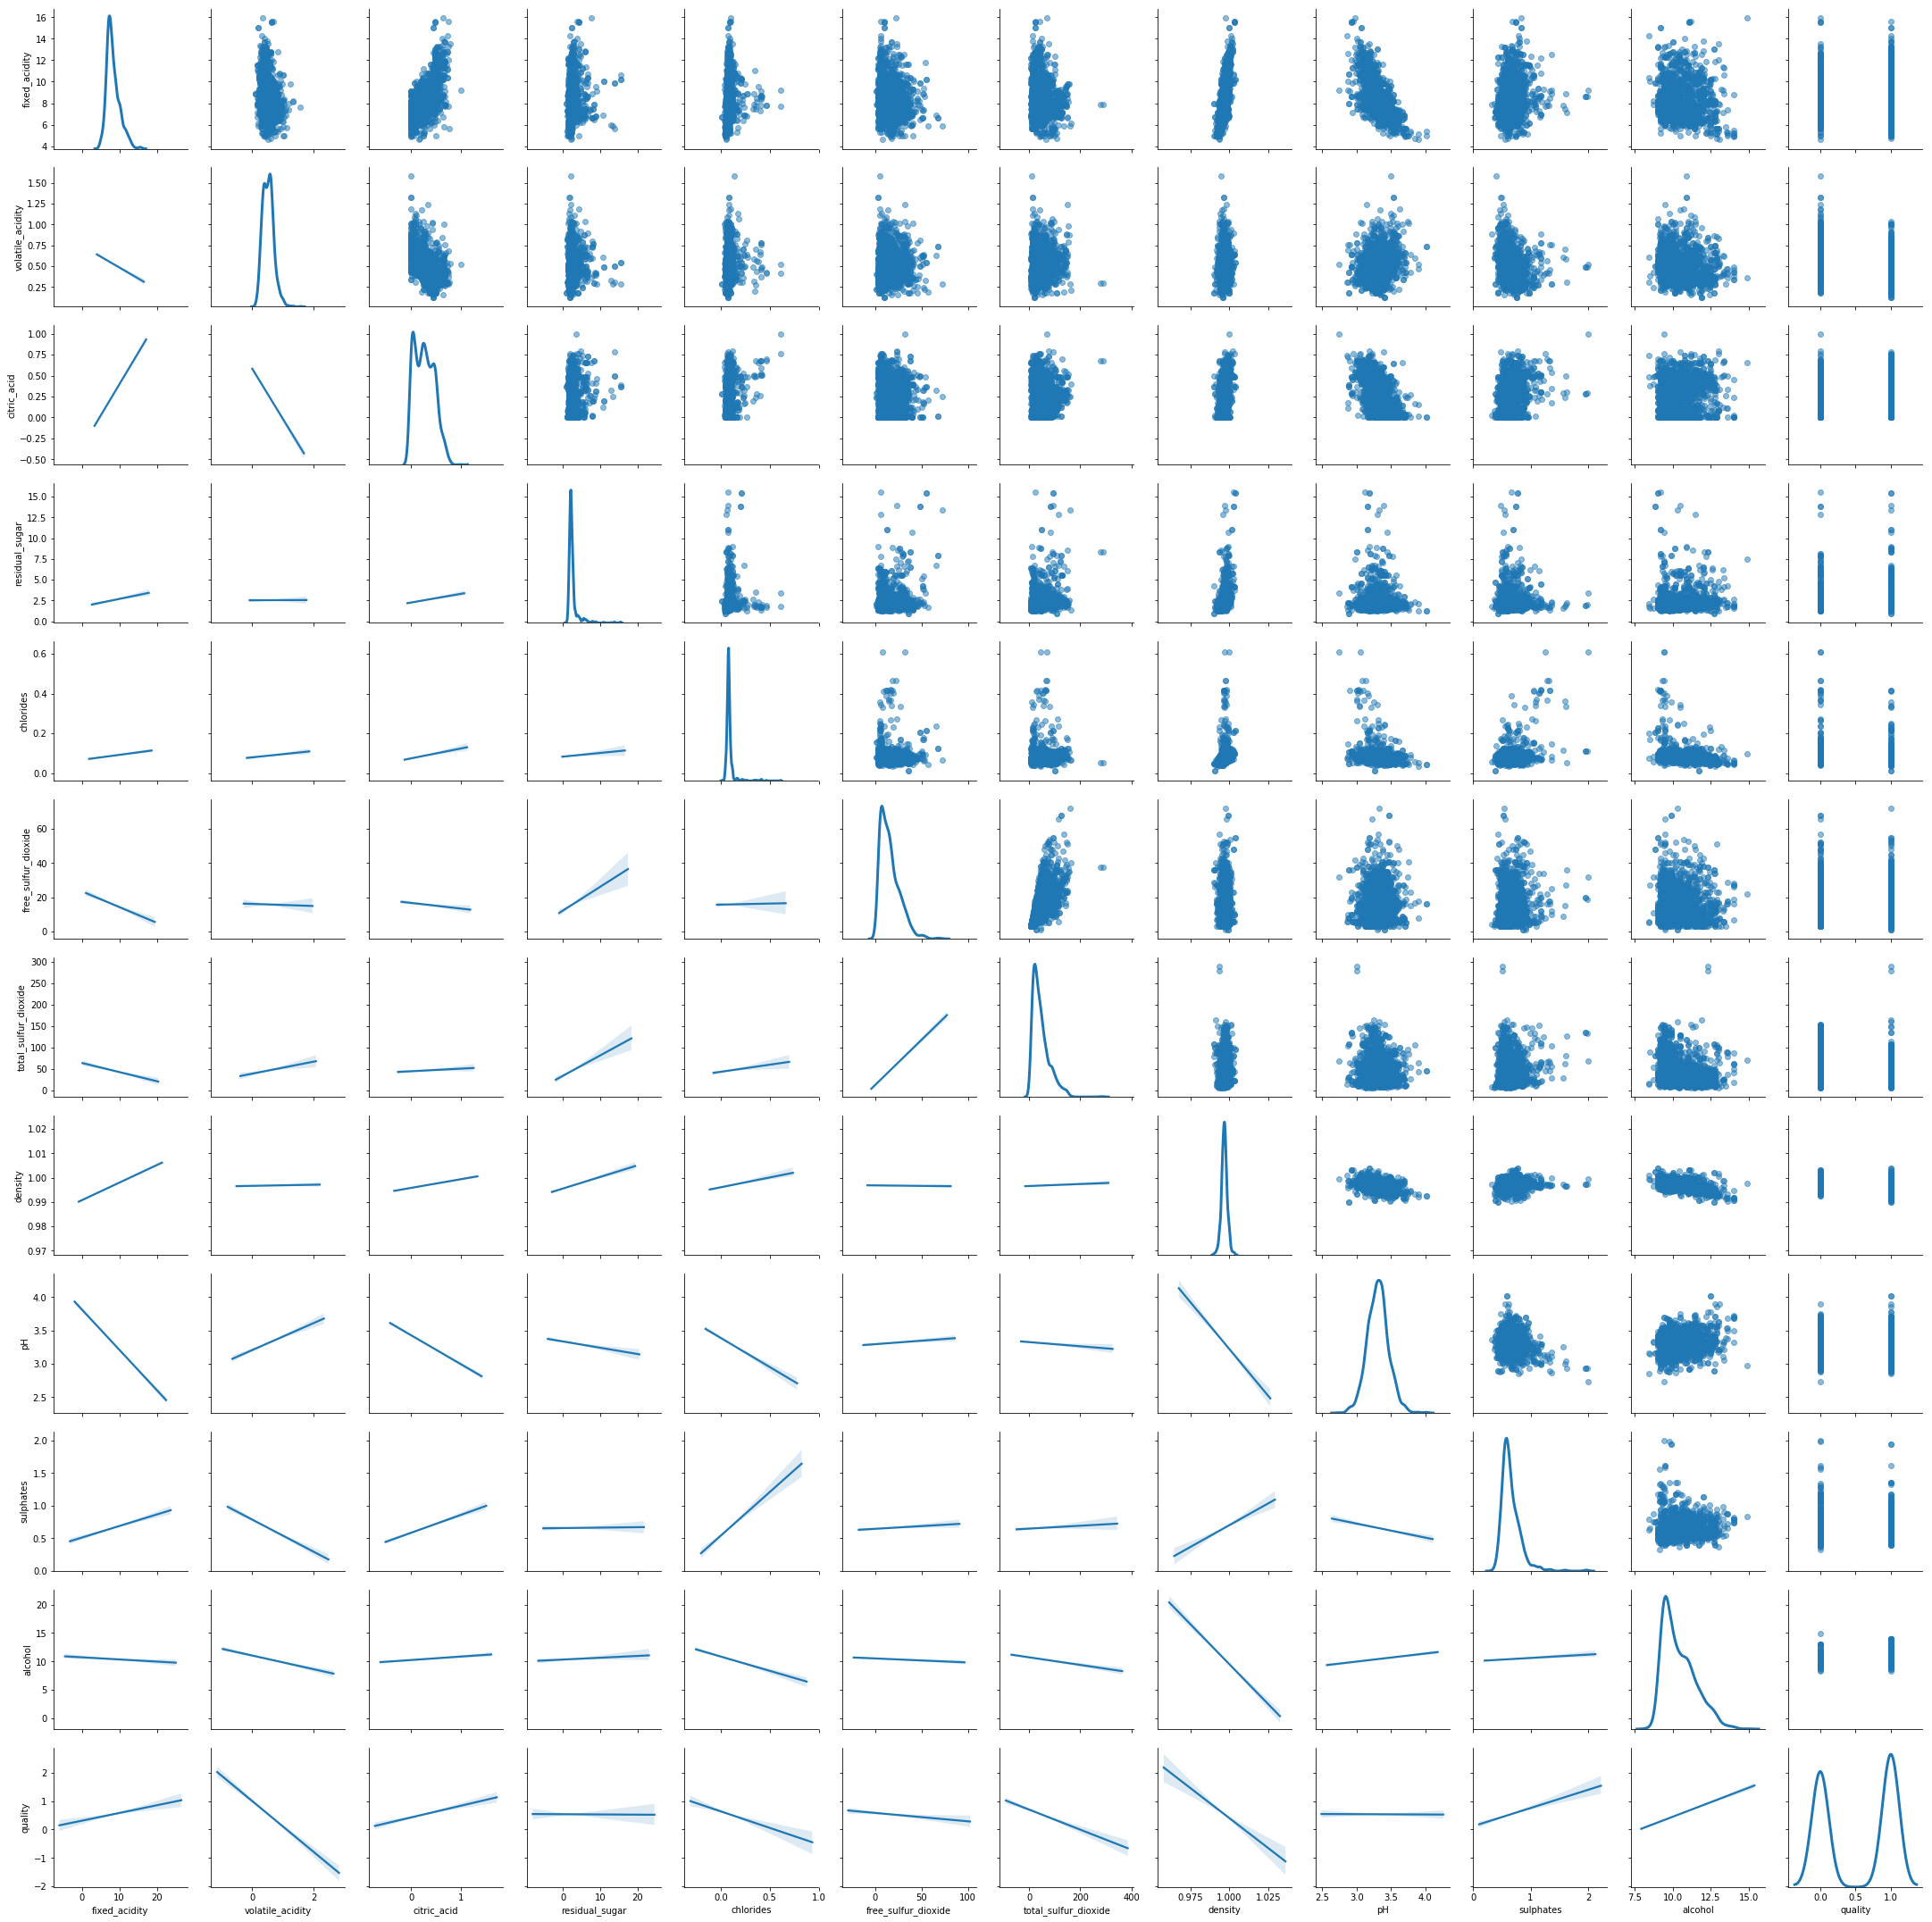

In [17]:
#pair plot 
g = sns.PairGrid(wine_qual , diag_sharey=False) 
g.map_upper(plt.scatter, alpha=.5) 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0)) 
g.map_diag(sns.kdeplot, lw=3)
plt.show()

The pair plot confirms some of the assumptions made from the boxplots.

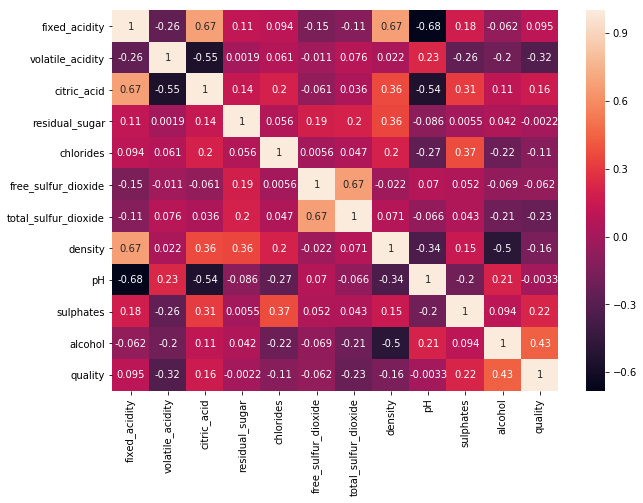

In [18]:
# Correleation Matrix

fig, ax = pyplot.subplots(figsize=(10, 7))
sns.heatmap(wine_qual.corr(),annot=True)
plt.show()

# Decision Tree


In [19]:
# Naive approach

In [20]:
X = wine_qual.drop('quality',1)
Y = wine_qual['quality']
 

In [21]:
start_time = time.time() # start timer 

# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt',
                                            max_depth=8, random_state=20,)

decision_tree.fit(X, Y)
print(cross_val_score(decision_tree, X, Y, cv=10))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer



[0.52795031 0.76397516 0.73913043 0.65838509 0.6875     0.76100629
 0.63522013 0.71698113 0.61006289 0.66666667]

--- 0.047872066497802734 seconds ---


In [22]:
from sklearn.model_selection import train_test_split

# train_test_split to create the necessary training and test groups

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(X, Y).score(X, Y))) 

With 25% Holdout: 0.6975
Testing on Sample: 0.8248905565978737


In [23]:
# create new feature based on the ranges of quality to help offset the outliers.

wine_qual['log_free_sulfur_dioxide'] = [math.log(x) for x in wine_qual.free_sulfur_dioxide]
wine_qual['log_total_sulfur_dioxide'] = [math.log(x) for x in wine_qual.total_sulfur_dioxide]

In [24]:
wine_qual.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,log_free_sulfur_dioxide,log_total_sulfur_dioxide
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,2.397895,3.526361
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,3.218876,4.204693


In [25]:
# Try again

X = wine_qual.drop('quality',1)
Y = wine_qual['quality'] 
 


decision_tree.fit(X, Y)
print(cross_val_score(decision_tree, X, Y, cv=5))

[0.640625   0.64375    0.65625    0.6125     0.66144201]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(X, Y).score(X, Y)))

With 25% Holdout: 0.67
Testing on Sample: 0.8380237648530331


The model seems to be overfitting

In [27]:
# Automatic feature selection

import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'total_sulfur_dioxide', 'density', 'sulphates', 'alcohol', 'log_free_sulfur_dioxide', 'log_total_sulfur_dioxide']


In [28]:
# try oversampling target

ros = RandomOverSampler(random_state=20)
x_train_selected, y_train = ros.fit_sample(x_train_selected, y_train)

In [29]:
# Find best parameters using GridSearchCV

param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(2,10),max_features=range(1,5))
grid = GridSearchCV(decision_tree, param_grid, cv=10, scoring="accuracy", return_train_score=True)
grid.fit(x_train_selected, y_train)

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'max_leaf_nodes': range(2, 10), 'max_features': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [30]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 9}
0.7197802197802198


In [31]:
# Update parameters
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4, max_features=4, 
                                            max_leaf_nodes=9, random_state=20)

decision_tree.fit(x_train_selected, y_train)
print(cross_val_score(decision_tree, x_train_selected, y_train, cv=10))

[0.7421875  0.75       0.6796875  0.6484375  0.734375   0.71875
 0.6953125  0.74603175 0.68253968 0.8015873 ]


In [32]:
print('With 25% Holdout: ' + str(decision_tree.fit(x_train_selected, y_train).score(x_test_selected, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(X_selected, Y).score(X_selected, Y)))


With 25% Holdout: 0.73
Testing on Sample: 0.7417135709818636


The model doesn't seem to be overfitting as much.

In [33]:
#confusion matrix 
y_pred = decision_tree.predict(x_test_selected)
confusion_matrix(y_test,y_pred) 

array([[145,  37],
       [ 58, 160]], dtype=int64)

In [34]:
# Classification report

from sklearn.metrics import classification_report

target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       182
           1       0.81      0.73      0.77       218

   micro avg       0.76      0.76      0.76       400
   macro avg       0.76      0.77      0.76       400
weighted avg       0.77      0.76      0.76       400



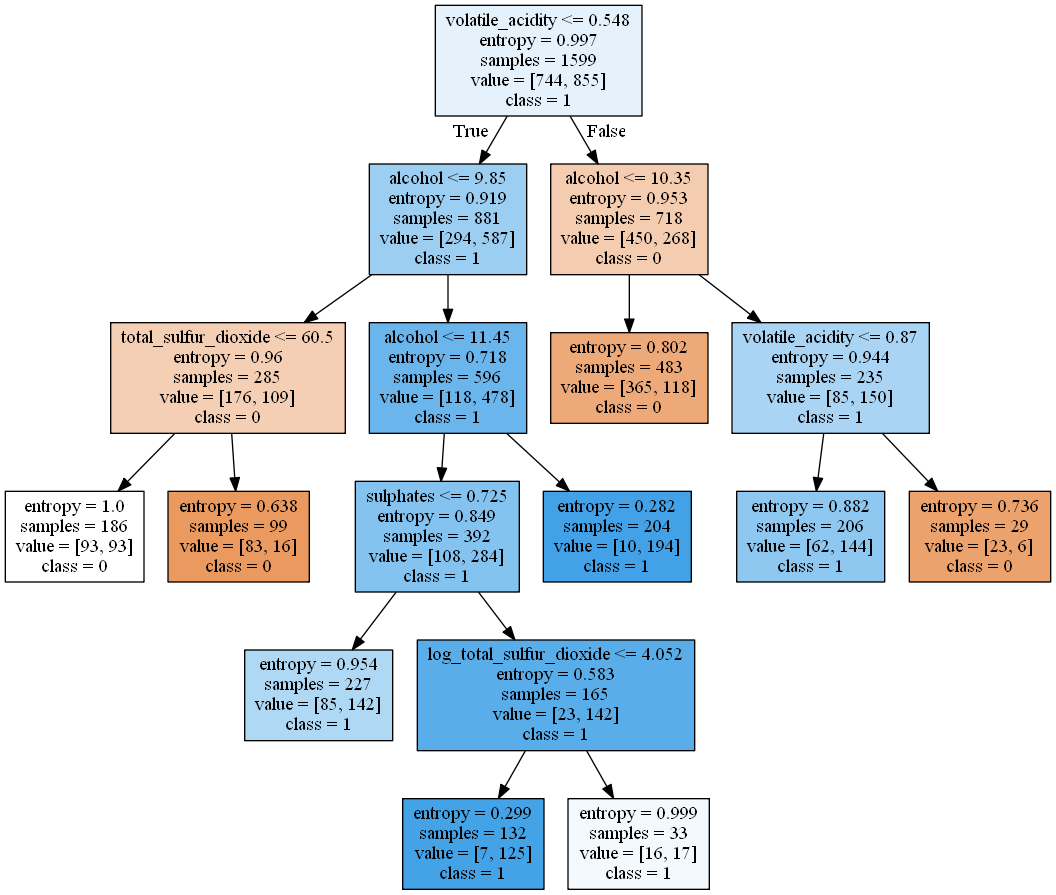

In [35]:
# Tree visualization
from IPython.display import Image
import pydotplus
import graphviz
 
#Rendertree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_selected.columns,
    class_names=['0','1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Trying a similar approach using PCA

In [36]:
X = wine_qual.drop('quality',1)
Y = wine_qual['quality'] 

In [37]:
# feature selection first

import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X, Y)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
 
 


['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'sulphates', 'alcohol', 'log_total_sulfur_dioxide']


In [38]:
# PCA
pca = PCA(n_components=4)
pca.fit(X_selected)  
pca_data = pca.fit_transform(X_selected)

In [39]:
start_time = time.time() # start timer 

# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt',
                                            max_depth=8, random_state=20,)

decision_tree.fit(pca_data, Y)
print(cross_val_score(decision_tree, pca_data, Y, cv=10))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer



[0.55279503 0.73913043 0.78881988 0.65838509 0.71875    0.86163522
 0.77358491 0.66037736 0.71069182 0.57232704]

--- 0.04986906051635742 seconds ---


In [40]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(pca_data, Y).score(pca_data, Y))) 

With 25% Holdout: 0.745
Testing on Sample: 0.8098811757348343


In [41]:
# Oversample 

ros = RandomOverSampler()
x_train_selected, y_train = ros.fit_sample(pca_data, Y)

In [42]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(2,10),max_features=range(1,5))
grid = GridSearchCV(decision_tree, param_grid, cv=10, scoring="accuracy", return_train_score=True)
grid.fit(x_train_selected, y_train)

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'max_leaf_nodes': range(2, 10), 'max_features': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [43]:
print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 4, 'max_features': 3, 'max_leaf_nodes': 8}
0.7192982456140351


In [44]:
start_time = time.time() # start timer  

# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth= 3, max_features=3, 
                                            max_leaf_nodes=7, random_state=20)

decision_tree.fit(x_train_selected, y_train)
print(cross_val_score(decision_tree, x_train_selected, y_train, cv=10))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.5755814  0.68604651 0.75581395 0.5872093  0.78488372 0.76470588
 0.73529412 0.75294118 0.7        0.69411765]

--- 0.03886222839355469 seconds ---


In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_train_selected, y_train, test_size=.25, random_state=20) 
    

print('With 25% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(pca_data, Y).score(pca_data, Y))) 



With 25% Holdout: 0.719626168224299
Testing on Sample: 0.7285803627267042


In [46]:
#confusion matrix 
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test,y_pred) 

array([[157,  42],
       [ 74, 155]], dtype=int64)

In [47]:
# Classification report

from sklearn.metrics import classification_report

target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       199
           1       0.79      0.68      0.73       229

   micro avg       0.73      0.73      0.73       428
   macro avg       0.73      0.73      0.73       428
weighted avg       0.74      0.73      0.73       428



In [48]:
PCAdf = pd.DataFrame(pca_data)
PCAdf.columns=('PC1','PC2','PC3','PC4')
PCAdf.head()

,PC1,PC2,PC3,PC4
0,-13.218769,-2.017218,-0.993683,-1.169804
1,22.045584,4.411595,-0.266983,-0.592499
2,7.171184,-2.496088,-0.518004,-0.603293
3,13.443096,-1.940714,2.962891,-0.303510
4,-13.218769,-2.017218,-0.993683,-1.169804


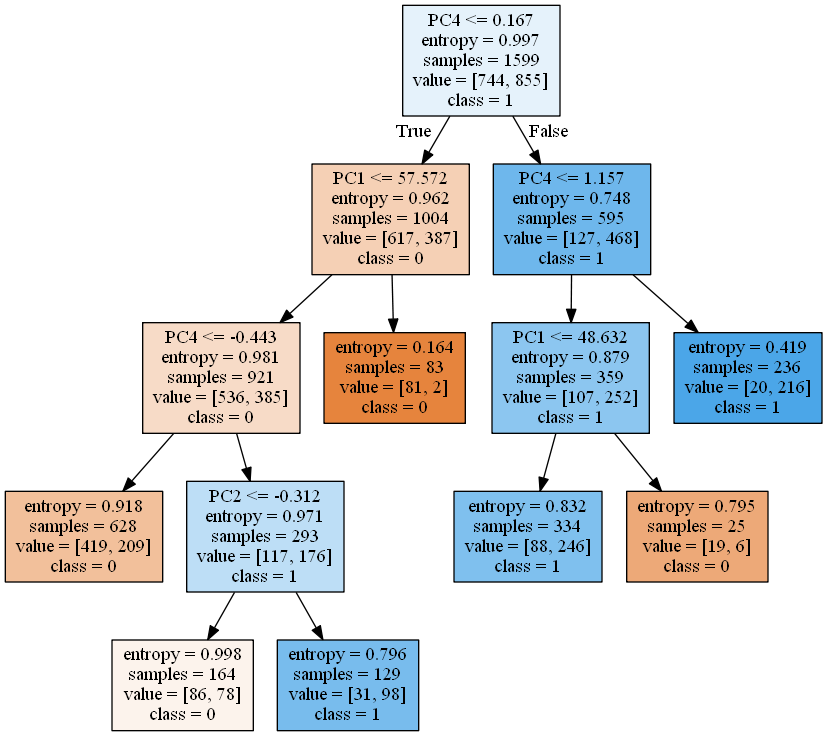

In [49]:
# Tree visualization
from IPython.display import Image
import pydotplus
import graphviz
 
#Rendertree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=PCAdf.columns,
    class_names=['0','1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Random Forrest

In [50]:
X = wine_qual.drop(['quality'],1) 
Y = wine_qual['quality']

In [51]:
start_time = time.time() # start timer
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features='sqrt') 
rfc.fit(X,Y)

print(cross_val_score(rfc, X, Y, cv=5))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.646875   0.68125    0.759375   0.71875    0.71159875]

--- 0.16471052169799805 seconds ---


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [52]:
from sklearn.model_selection import train_test_split
#Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(X, Y).score(X, Y))) 

With 25% Holdout: 0.7925
Testing on Sample: 0.9874921826141339


In [53]:
# Automatic feature selection with SelectKbest

import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'total_sulfur_dioxide', 'density', 'sulphates', 'alcohol', 'log_free_sulfur_dioxide', 'log_total_sulfur_dioxide']


In [54]:
start_time = time.time() # start timer
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features='sqrt', ) 
rfc.fit(x_train_selected,y_train)

print(cross_val_score(rfc, x_train_selected, y_train, cv=5))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.7966805  0.78008299 0.78661088 0.80753138 0.75313808]

--- 0.14875173568725586 seconds ---


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
print('With 25% Holdout: ' + str(rfc.fit(x_train_selected, y_train).score(x_test_selected, y_test)))
print('Testing on Sample: ' + str(rfc.fit(X_selected, Y).score(X_selected, Y)))

With 25% Holdout: 0.78
Testing on Sample: 0.9906191369606003


In [56]:
# Oversample
ros = RandomOverSampler(random_state=20)
x_train_selected, y_train = ros.fit_sample(x_train_selected, y_train)

In [57]:
print('With 25% Holdout: ' + str(rfc.fit(x_train_selected, y_train).score(x_test_selected, y_test)))
print('Testing on Sample: ' + str(rfc.fit(X_selected, Y).score(X_selected, Y)))
 

With 25% Holdout: 0.785
Testing on Sample: 0.9906191369606003


In [58]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(2,10),max_features=range(1,5))
grid = GridSearchCV(rfc, param_grid, cv=10, scoring="accuracy", return_train_score=True)
grid.fit(x_train_selected, y_train)

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=20, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'max_leaf_nodes': range(2, 10), 'max_features': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [59]:
print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 8}
0.7574568288854003


In [60]:
start_time = time.time() # start timer
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features=4, 
                                      max_depth=4,max_leaf_nodes=8) 
rfc.fit(x_train_selected,y_train)

print(cross_val_score(rfc, x_train_selected, y_train, cv=5))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.71484375 0.73828125 0.75590551 0.77165354 0.7519685 ]

--- 0.09030532836914062 seconds ---


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [61]:
print('With 25% Holdout: ' + str(rfc.fit(x_train_selected, y_train).score(x_test_selected, y_test)))
print('Testing on Sample: ' + str(rfc.fit(X_selected, Y).score(X_selected, Y))) 

With 25% Holdout: 0.735
Testing on Sample: 0.7698561601000625


In [62]:
#confusion matrix 
y_pred = rfc.predict(x_test_selected)
confusion_matrix(y_test,y_pred) 

array([[141,  41],
       [ 43, 175]], dtype=int64)

In [63]:
# Classification report
y_pred = rfc.predict(x_test_selected)
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       182
           1       0.81      0.80      0.81       218

   micro avg       0.79      0.79      0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

